### Import Necessary Libraries

In [77]:
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, TimestampType, DoubleType
from pyspark.sql.functions import to_date,from_unixtime, unix_timestamp, col, datediff, lit, array,monotonically_increasing_id,when,udf,collect_list,count,monotonically_increasing_id,isnan
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer,MinMaxScaler,VectorAssembler, Imputer
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans, BisectingKMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.ml.evaluation import ClusteringEvaluator
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import functions as F

### Creating a Spark Object

In [3]:
spark = SparkSession.builder.getOrCreate()

### Loading the Data Set 

1. As we have the header already in the dataset.
2. We have **header** as **true** in the below code, as well as initially we are letting spark object decide the schema as well, hence **infershema** is **True** as well

In [4]:
csv_file_path = r"C:\Users\piyus\Desktop\BankCustomerSegmentation\BankCustomerSegmentation\bank_transactions.csv"
sdf = spark.read.option("header","true").csv(csv_file_path, inferSchema = True)

In [5]:
sdf.columns

['TransactionID',
 'CustomerID',
 'CustomerDOB',
 'CustGender',
 'CustLocation',
 'CustAccountBalance',
 'TransactionDate',
 'TransactionTime',
 'TransactionAmount (INR)']

### Creating a a backup data set of the original one right at the start

In [6]:
backup_df = sdf# creating a Backup

##### Distribution of gender 

In [7]:
sdf.groupBy("CustGender").count().show()

+----------+------+
|CustGender| count|
+----------+------+
|         F|281936|
|      null|  1100|
|         M|765530|
|         T|     1|
+----------+------+



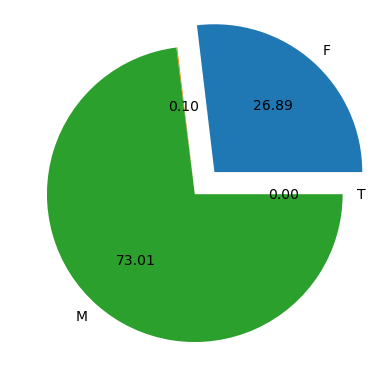

In [8]:
gender=ps.DataFrame(sdf.groupBy("CustGender").count())
plt.pie(gender["count"].to_numpy(),labels=gender["CustGender"].to_numpy(),explode=[0.2,0,0,0],autopct='%.2f')
plt.show()

#### We are creating a list of numberical columns with List Comprehension in the below step, the aim is to use the describe method on all the numerical columns

In [9]:
numeric_columns = sdf.select([col for col, dtype in sdf.dtypes if dtype == "double" or dtype == "int"])
numeric_columns.describe().show()

+-------+------------------+------------------+-----------------------+
|summary|CustAccountBalance|   TransactionTime|TransactionAmount (INR)|
+-------+------------------+------------------+-----------------------+
|  count|           1046198|           1048567|                1048567|
|   mean|115403.54005622225|157087.52939297154|     1574.3350034571092|
| stddev| 846485.3806006608| 51261.85402232925|      6574.742978454011|
|    min|               0.0|                 0|                    0.0|
|    max|     1.150354951E8|            235959|             1560034.99|
+-------+------------------+------------------+-----------------------+



### We can afford to remove the NaN values, as the column with highest number of null value only consists of 5.5 percent of null values

In [10]:
null_counts = sdf.agg(*[F.sum(F.col(column).isNull().cast("int")).alias(column) for column in sdf.columns])
null_counts.show()

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|            0|         0|          0|      1100|         151|              2369|              0|              0|                      0|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+



##### Dropping transaction ID and Customer ID  aand transaction Time as it hardly carries any importance in finding the clusters

In [11]:
sdf_cleaned = sdf.drop('TransactionID', 'CustomerID', 'TransactionTime')
print(f"{len(sdf_cleaned.columns)}")

6


##### Converting the Transaction Date and Customer Date of Birth to Timestamp

In [12]:
sdf_cleaned.printSchema()

root
 |-- CustomerDOB: string (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: double (nullable = true)
 |-- TransactionDate: date (nullable = true)
 |-- TransactionAmount (INR): double (nullable = true)



In [13]:
sdf_cleaned = sdf_cleaned.withColumn("CustomerDOB",sdf_cleaned["CustomerDOB"].cast(DateType()))   # Converting the CustomerDOB to DateType()
sdf_cleaned.show(5)

+-----------+----------+------------+------------------+---------------+-----------------------+
|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|
+-----------+----------+------------+------------------+---------------+-----------------------+
| 1994-01-10|         F|  JAMSHEDPUR|          17819.05|     2016-08-02|                   25.0|
| 1957-04-04|         M|     JHAJJAR|           2270.69|     2016-08-02|                27999.0|
| 1996-11-26|         F|      MUMBAI|          17874.44|     2016-08-02|                  459.0|
| 1973-09-14|         F|      MUMBAI|         866503.21|     2016-08-02|                 2060.0|
| 1988-03-24|         F| NAVI MUMBAI|           6714.43|     2016-08-02|                 1762.5|
+-----------+----------+------------+------------------+---------------+-----------------------+
only showing top 5 rows



In [14]:
sdf_cleaned = sdf_cleaned.withColumn("TransactionDate",sdf_cleaned["TransactionDate"].cast(DateType()))   # Converting the CustomerDOB to DateType()
sdf_cleaned.show(5)

+-----------+----------+------------+------------------+---------------+-----------------------+
|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|
+-----------+----------+------------+------------------+---------------+-----------------------+
| 1994-01-10|         F|  JAMSHEDPUR|          17819.05|     2016-08-02|                   25.0|
| 1957-04-04|         M|     JHAJJAR|           2270.69|     2016-08-02|                27999.0|
| 1996-11-26|         F|      MUMBAI|          17874.44|     2016-08-02|                  459.0|
| 1973-09-14|         F|      MUMBAI|         866503.21|     2016-08-02|                 2060.0|
| 1988-03-24|         F| NAVI MUMBAI|           6714.43|     2016-08-02|                 1762.5|
+-----------+----------+------------+------------------+---------------+-----------------------+
only showing top 5 rows



In [15]:
sdf_cleaned.printSchema()

root
 |-- CustomerDOB: date (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: double (nullable = true)
 |-- TransactionDate: date (nullable = true)
 |-- TransactionAmount (INR): double (nullable = true)



In [16]:
null_counts = sdf_cleaned.agg(*[F.sum(F.col(column).isNull().cast("int")).alias(column) for column in sdf_cleaned.columns])
null_counts.show()

+-----------+----------+------------+------------------+---------------+-----------------------+
|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|
+-----------+----------+------------+------------------+---------------+-----------------------+
|      60736|      1100|         151|              2369|              0|                      0|
+-----------+----------+------------+------------------+---------------+-----------------------+



In [17]:
sdf_cleaned.show()

+-----------+----------+------------+------------------+---------------+-----------------------+
|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|
+-----------+----------+------------+------------------+---------------+-----------------------+
| 1994-01-10|         F|  JAMSHEDPUR|          17819.05|     2016-08-02|                   25.0|
| 1957-04-04|         M|     JHAJJAR|           2270.69|     2016-08-02|                27999.0|
| 1996-11-26|         F|      MUMBAI|          17874.44|     2016-08-02|                  459.0|
| 1973-09-14|         F|      MUMBAI|         866503.21|     2016-08-02|                 2060.0|
| 1988-03-24|         F| NAVI MUMBAI|           6714.43|     2016-08-02|                 1762.5|
| 1972-10-08|         F|    ITANAGAR|           53609.2|     2016-08-02|                  676.0|
| 1992-01-26|         F|      MUMBAI|            973.46|     2016-08-02|                  566.0|
| 1982-01-27|         M|      

##### Remvoed the duplicated rows  from the data set

In [18]:
sdf_cleaned = sdf_cleaned.na.drop(subset=['CustomerDOB'])
sdf_cleaned.count()

987831

In [19]:
duplicated_count = sdf_cleaned.groupBy(sdf_cleaned.columns).count().filter("count > 1").count()

In [20]:
duplicated_count

30558

In [21]:
sdf_deduplicated = sdf_cleaned.dropDuplicates()
sdf_deduplicated.count()

947525

##### There were erroneous age at source, hence dropped

In [22]:
sdf_cleaned = sdf_deduplicated[sdf_deduplicated['CustomerDOB'] < '2000-01-01']
sdf_cleaned.show(5)

+-----------+----------+--------------+------------------+---------------+-----------------------+
|CustomerDOB|CustGender|  CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|
+-----------+----------+--------------+------------------+---------------+-----------------------+
| 1967-05-04|         M|         DUBAI|           6190.71|     2016-08-01|                  878.0|
| 1996-04-19|         M|AMBEDKAR NAGAR|             84.91|     2016-08-07|                   88.0|
| 1974-03-16|         F|     NEW DELHI|          15147.88|     2016-10-21|                 1000.0|
| 1984-10-16|         F|   NAVI MUMBAI|          10577.72|     2016-10-21|                 1045.0|
| 1988-04-07|         M|     BENGALURU|           3040.43|     2016-10-21|                  295.0|
+-----------+----------+--------------+------------------+---------------+-----------------------+
only showing top 5 rows



In [23]:
null_counts = sdf_cleaned.agg(*[F.sum(F.col(column).isNull().cast("int")).alias(column) for column in sdf_cleaned.columns])
null_counts.show()

+-----------+----------+------------+------------------+---------------+-----------------------+
|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|
+-----------+----------+------------+------------------+---------------+-----------------------+
|          0|       140|         147|              2027|              0|                      0|
+-----------+----------+------------+------------------+---------------+-----------------------+



#### The CustomerAccount Balance is highly skewed, so we will be filling it with the median as median is way less sensative to outliers than mean

In [24]:
imputer = Imputer(strategy = 'median', inputCol = 'CustAccountBalance' , outputCol= 'CustAccountBalance')
sdf_cleaned = imputer.fit(sdf_cleaned).transform(sdf_cleaned)

In [25]:
null_counts = sdf_cleaned.agg(*[F.sum(F.col(column).isNull().cast("int")).alias(column) for column in sdf_cleaned.columns])
null_counts.show()

+-----------+----------+------------+------------------+---------------+-----------------------+
|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|
+-----------+----------+------------+------------------+---------------+-----------------------+
|          0|       140|         147|                 0|              0|                      0|
+-----------+----------+------------+------------------+---------------+-----------------------+



In [26]:
mode_result = sdf_cleaned.groupBy("CustGender").count().orderBy(col("count").desc()).first()
mode_CustGender = mode_result["CustGender"]
sdf_cleaned = sdf_cleaned.fillna({"CustGender": mode_CustGender}) # Fill null values with the mode

In [27]:
mode_result

Row(CustGender='M', count=683015)

In [28]:
mode_CustGender

'M'

In [29]:
mode_result_2 = sdf_cleaned.groupBy("CustLocation").count().orderBy(col("count").desc()).first()
mode_CustLocation = mode_result_2["CustLocation"]
sdf_cleaned = sdf_cleaned.fillna({"CustLocation": mode_CustLocation}) # Fill null values with the mode

In [30]:
mode_result_2

Row(CustLocation='MUMBAI', count=94555)

In [31]:
mode_CustLocation

'MUMBAI'

In [32]:
null_counts = sdf_cleaned.agg(*[F.sum(F.col(column).isNull().cast("int")).alias(column) for column in sdf_cleaned.columns])
null_counts.show()

+-----------+----------+------------+------------------+---------------+-----------------------+
|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|
+-----------+----------+------------+------------------+---------------+-----------------------+
|          0|         0|           0|                 0|              0|                      0|
+-----------+----------+------------+------------------+---------------+-----------------------+



In [33]:
print(f"Shape after the data Cleaning and Filling : ({sdf_cleaned.count()},{len(sdf.columns)})")
sdf_cleaned.show(5,truncate=False)

Shape after the data Cleaning and Filling : (946481,9)
+-----------+----------+--------------+------------------+---------------+-----------------------+
|CustomerDOB|CustGender|CustLocation  |CustAccountBalance|TransactionDate|TransactionAmount (INR)|
+-----------+----------+--------------+------------------+---------------+-----------------------+
|1967-05-04 |M         |DUBAI         |6190.71           |2016-08-01     |878.0                  |
|1996-04-19 |M         |AMBEDKAR NAGAR|84.91             |2016-08-07     |88.0                   |
|1974-03-16 |F         |NEW DELHI     |15147.88          |2016-10-21     |1000.0                 |
|1984-10-16 |F         |NAVI MUMBAI   |10577.72          |2016-10-21     |1045.0                 |
|1988-04-07 |M         |BENGALURU     |3040.43           |2016-10-21     |295.0                  |
+-----------+----------+--------------+------------------+---------------+-----------------------+
only showing top 5 rows



In [34]:
sdf_cleaned.toPandas().to_csv(r"C:\Users\piyus\Desktop\BankCustomerSegmentation\BankCustomerSegmentation\CSVCleaned\sdf_cleaned.csv")

#### Here as we have the birth date, we will calculate the age of the Customer at the time he made the transaction 
#####  TransactionDate - CustomerDate = No. of days (Will give us number of days between the 2 Date Columns)
#####  No. of Days / 365 - is going to give us float of years 
#####  Casting it to the IntegerType  as the age is always said to be as a whole Number
#####  As now we are creating a correlated column of Age, we should drop the CustomerDOB column for reducing the Multicolliearity 

In [35]:
sdf_cleaned.show()

+-----------+----------+-------------------+------------------+---------------+-----------------------+
|CustomerDOB|CustGender|       CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|
+-----------+----------+-------------------+------------------+---------------+-----------------------+
| 1967-05-04|         M|              DUBAI|           6190.71|     2016-08-01|                  878.0|
| 1996-04-19|         M|     AMBEDKAR NAGAR|             84.91|     2016-08-07|                   88.0|
| 1974-03-16|         F|          NEW DELHI|          15147.88|     2016-10-21|                 1000.0|
| 1984-10-16|         F|        NAVI MUMBAI|          10577.72|     2016-10-21|                 1045.0|
| 1988-04-07|         M|          BENGALURU|           3040.43|     2016-10-21|                  295.0|
| 1994-06-20|         F|      JAGATSINGHPUR|             97.93|     2016-10-21|                   65.0|
| 1977-09-23|         M|       NAGARI THANE|          175655.8| 

In [36]:
sdf_cleaned = sdf_cleaned.withColumn('CustomerAge', datediff('TransactionDate','CustomerDOB')/365)
sdf_cleaned = sdf_cleaned.withColumn('CustomerAge', col('CustomerAge').cast(IntegerType()))
sdf_cleaned.show(5)
sdf_cleaned = sdf_cleaned.drop("CustomerDOB")

+-----------+----------+--------------+------------------+---------------+-----------------------+-----------+
|CustomerDOB|CustGender|  CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|CustomerAge|
+-----------+----------+--------------+------------------+---------------+-----------------------+-----------+
| 1967-05-04|         M|         DUBAI|           6190.71|     2016-08-01|                  878.0|         49|
| 1996-04-19|         M|AMBEDKAR NAGAR|             84.91|     2016-08-07|                   88.0|         20|
| 1974-03-16|         F|     NEW DELHI|          15147.88|     2016-10-21|                 1000.0|         42|
| 1984-10-16|         F|   NAVI MUMBAI|          10577.72|     2016-10-21|                 1045.0|         32|
| 1988-04-07|         M|     BENGALURU|           3040.43|     2016-10-21|                  295.0|         28|
+-----------+----------+--------------+------------------+---------------+-----------------------+-----------+
o

In [37]:
sdf_cleaned_backup = sdf_cleaned

In [38]:
df = sdf_cleaned.toPandas()
df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),CustomerAge
0,M,DUBAI,6190.71,2016-08-01,878.0,49
1,M,AMBEDKAR NAGAR,84.91,2016-08-07,88.0,20
2,F,NEW DELHI,15147.88,2016-10-21,1000.0,42
3,F,NAVI MUMBAI,10577.72,2016-10-21,1045.0,32
4,M,BENGALURU,3040.43,2016-10-21,295.0,28


In [39]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True)

In [40]:
df2 = df.copy()
df2.set_index('TransactionDate', inplace=True)

In [41]:
df2.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge
TransactionDate,,,,,
2016-08-01,M,DUBAI,6190.71,878.0,49
2016-08-07,M,AMBEDKAR NAGAR,84.91,88.0,20
2016-10-21,F,NEW DELHI,15147.88,1000.0,42
2016-10-21,F,NAVI MUMBAI,10577.72,1045.0,32
2016-10-21,M,BENGALURU,3040.43,295.0,28


In [42]:
daily_total = df2.groupby(pd.Grouper(freq='W'))['TransactionAmount (INR)'].sum()

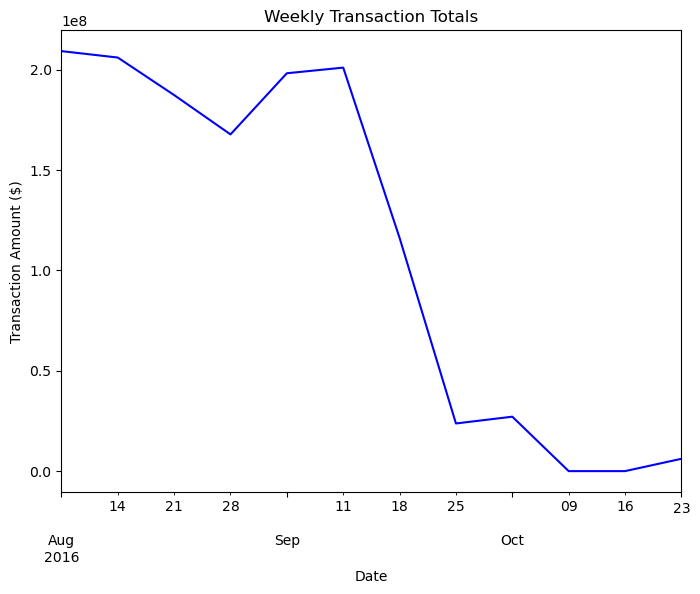

In [43]:
fig = plt.subplots(figsize = (8, 6))
daily_total.plot(color='blue', linestyle='solid')
plt.title('Weekly Transaction Totals')
plt.xlabel('Date')
plt.ylabel('Transaction Amount ($)')
plt.show()

### Now let us try to acheive the Encoding in a few specific columns.

##### StringIndexer comes in handy for PySpark if we need to have Numbers(Float Values) assigned to Strings
##### Again now we can go ahead and drop the CustGender Column

#### Encoding the CustGender column

In [44]:
sdf_cleaned.groupBy("CustGender").count().show() # To check the the distribution of Gender with respect to the number of transactions done!

+----------+------+
|CustGender| count|
+----------+------+
|         F|263326|
|         M|683155|
+----------+------+



In [45]:
indexer = StringIndexer(inputCol='CustGender', outputCol='GenderEncoded')
sdf_cleaned = indexer.fit(sdf_cleaned).transform(sdf_cleaned)
sdf_cleaned = sdf_cleaned.withColumn('GenderEncoded', col('GenderEncoded').cast(IntegerType()))
sdf_cleaned = sdf_cleaned.drop("CustGender")
sdf_cleaned.show(5)

+--------------+------------------+---------------+-----------------------+-----------+-------------+
|  CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|CustomerAge|GenderEncoded|
+--------------+------------------+---------------+-----------------------+-----------+-------------+
|         DUBAI|           6190.71|     2016-08-01|                  878.0|         49|            0|
|AMBEDKAR NAGAR|             84.91|     2016-08-07|                   88.0|         20|            0|
|     NEW DELHI|          15147.88|     2016-10-21|                 1000.0|         42|            1|
|   NAVI MUMBAI|          10577.72|     2016-10-21|                 1045.0|         32|            1|
|     BENGALURU|           3040.43|     2016-10-21|                  295.0|         28|            0|
+--------------+------------------+---------------+-----------------------+-----------+-------------+
only showing top 5 rows



In [46]:
sdf_cleaned.groupBy("GenderEncoded").count().show() # To check the the distribution of Gender with respect to the number of transactions done!

+-------------+------+
|GenderEncoded| count|
+-------------+------+
|            1|263326|
|            0|683155|
+-------------+------+



#### Endcoding the CustLocation Column

In [47]:
indexer_location = StringIndexer(inputCol='CustLocation', outputCol='LocationEncoded')
sdf_cleaned = indexer_location.fit(sdf_cleaned).transform(sdf_cleaned)
sdf_cleaned = sdf_cleaned.withColumn('LocationEncoded', col('LocationEncoded').cast(IntegerType()))
sdf_cleaned = sdf_cleaned.drop("CustLocation")
sdf_cleaned.show(5)

+------------------+---------------+-----------------------+-----------+-------------+---------------+
|CustAccountBalance|TransactionDate|TransactionAmount (INR)|CustomerAge|GenderEncoded|LocationEncoded|
+------------------+---------------+-----------------------+-----------+-------------+---------------+
|           6190.71|     2016-08-01|                  878.0|         49|            0|            173|
|             84.91|     2016-08-07|                   88.0|         20|            0|            665|
|          15147.88|     2016-10-21|                 1000.0|         42|            1|              2|
|          10577.72|     2016-10-21|                 1045.0|         32|            1|             12|
|           3040.43|     2016-10-21|                  295.0|         28|            0|             45|
+------------------+---------------+-----------------------+-----------+-------------+---------------+
only showing top 5 rows



In [48]:
sdf_cleaned

DataFrame[CustAccountBalance: double, TransactionDate: date, TransactionAmount (INR): double, CustomerAge: int, GenderEncoded: int, LocationEncoded: int]

In [49]:
ip_columns = ['CustAccountBalance','TransactionAmount (INR)','CustomerAge','GenderEncoded','LocationEncoded']
assembler = VectorAssembler(inputCols=ip_columns, outputCol="features")# Assemble features into a Vector column
df = assembler.transform(sdf_cleaned)
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features") # Initialize the MinMaxScaler
scaler_model = scaler.fit(df)
sdf_scaled = scaler_model.transform(df)# Fit and transform the data using the scaler
sdf_scaled.show(5)# Show the scaled data

+------------------+---------------+-----------------------+-----------+-------------+---------------+-------------------------------+------------------------------------------------------------------------------------------+
|CustAccountBalance|TransactionDate|TransactionAmount (INR)|CustomerAge|GenderEncoded|LocationEncoded|features                       |scaled_features                                                                           |
+------------------+---------------+-----------------------+-----------+-------------+---------------+-------------------------------+------------------------------------------------------------------------------------------+
|6190.71           |2016-08-01     |878.0                  |49         |0            |173            |[6190.71,878.0,49.0,0.0,173.0] |[5.381565050525001E-5,5.628078893281746E-4,0.4714285714285714,0.0,0.021162079510703365]   |
|84.91             |2016-08-07     |88.0                   |20         |0            |665       

###### Creating a final Dataset that will be passed to the model

In [52]:
final_data = sdf_scaled.drop("CustAccountBalance","TransactionDate","TransactionAmount (INR)","CustomerAge","LocationEncoded","features","GenderEncoded")
final_data.show(5,truncate=False)

+------------------------------------------------------------------------------------------+
|scaled_features                                                                           |
+------------------------------------------------------------------------------------------+
|[5.381565050525001E-5,5.628078893281746E-4,0.4714285714285714,0.0,0.021162079510703365]   |
|[7.38120003101547E-7,5.6408991185511806E-5,0.05714285714285714,0.0,0.08134556574923547]   |
|[1.3168005220329598E-4,6.410112634717252E-4,0.37142857142857144,1.0,2.4464831804281347E-4]|
|[9.195179271236952E-5,6.698567703279527E-4,0.22857142857142856,1.0,0.0014678899082568807] |
|[2.643036392686417E-5,1.890983227241589E-4,0.17142857142857143,0.0,0.005504587155963303]  |
+------------------------------------------------------------------------------------------+
only showing top 5 rows



In [54]:
# Select the features to be used for clustering and assemble them into a vector column
feature_cols = ["scaled_features"]  # Replace with your feature column names
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(final_data)

In [55]:
data=data.drop("scaled_features")

In [56]:
data.show()

+--------------------+
|            features|
+--------------------+
|[5.38156505052500...|
|[7.38120003101547...|
|[1.31680052203295...|
|[9.19517927123695...|
|[2.64303639268641...|
|[8.51302460296013...|
|[0.00152697043505...|
|[0.00267142528254...|
|[0.00134330764487...|
|[8.80194412272321...|
|[9.96307269337775...|
|[2.93641279768786...|
|[2.58248638597809...|
|[4.42228461361227...|
|[7.55712833890345...|
|[2.75889628435215...|
|[1.51327900878482...|
|[9.89633676988451...|
|[1.27919212997762...|
|[3.60540022572563...|
+--------------------+
only showing top 20 rows



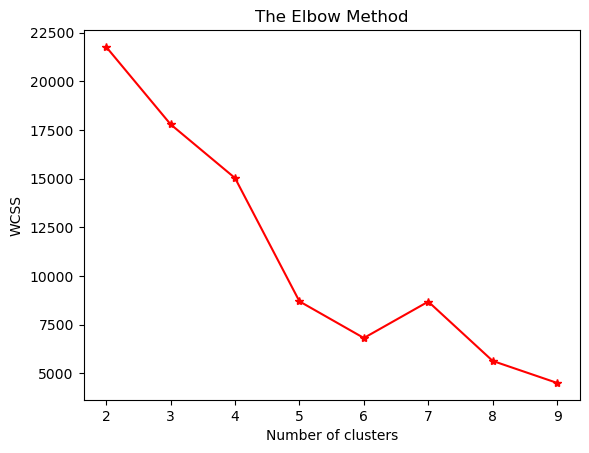

In [58]:
# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(2, 10):
    kmeans = KMeans().setK(i).setSeed(23)
    model = kmeans.fit(data)
    wcss.append(model.summary.trainingCost)  # Equivalent to Sklearns ._inertia

# Plot the Elbow Method graph
plt.plot(range(2, 10), wcss, marker='*', color='r')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


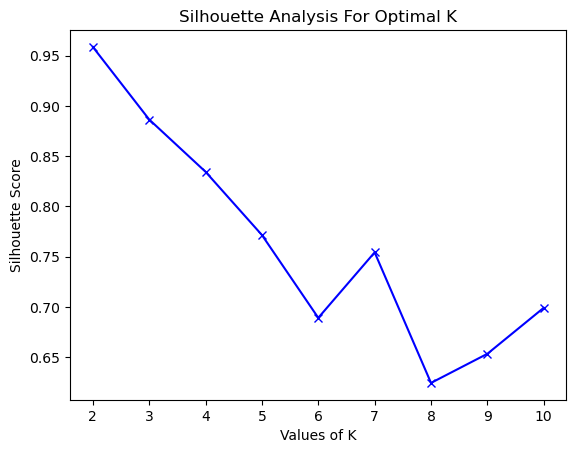

In [59]:
range_n_clusters=[2,3,4,5,6,7,8,9,10]
silhouette_scores = []
for num_clusters in range_n_clusters:
    kmeans = KMeans().setK(num_clusters).setSeed(23)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Plot the Silhouette Analysis graph
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal K')
plt.show()

In [60]:
kmeans = KMeans().setK(2).setSeed(23)
model = kmeans.fit(data)
predictions = model.transform(data)
predictions.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[5.38156505052500...|         0|
|[7.38120003101547...|         0|
|[1.31680052203295...|         1|
|[9.19517927123695...|         1|
|[2.64303639268641...|         0|
|[8.51302460296013...|         1|
|[0.00152697043505...|         0|
|[0.00267142528254...|         0|
|[0.00134330764487...|         0|
|[8.80194412272321...|         1|
|[9.96307269337775...|         0|
|[2.93641279768786...|         1|
|[2.58248638597809...|         0|
|[4.42228461361227...|         0|
|[7.55712833890345...|         1|
|[2.75889628435215...|         0|
|[1.51327900878482...|         0|
|[9.89633676988451...|         1|
|[1.27919212997762...|         0|
|[3.60540022572563...|         0|
+--------------------+----------+
only showing top 20 rows



In [87]:
DF1 = sdf_cleaned_backup.withColumn("row_id", monotonically_increasing_id())
DF2 = predictions.withColumn("row_id", monotonically_increasing_id())

In [88]:
result_df = DF1.join(DF2, ("row_id")).drop("row_id")

In [89]:
result_df.show(5)

+----------+--------------------+------------------+---------------+-----------------------+-----------+--------------------+----------+
|CustGender|        CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|CustomerAge|            features|prediction|
+----------+--------------------+------------------+---------------+-----------------------+-----------+--------------------+----------+
|         M|               DUBAI|           6190.71|     2016-08-01|                  878.0|         49|[5.38156505052500...|         0|
|         M|           NEW DELHI|         307308.73|     2016-10-21|                51750.0|         25|[0.00267142528254...|         0|
|         M|           BANGALORE|           4147.49|     2016-09-22|                   30.0|         26|[3.60540022572563...|         0|
|         M|            KOLHAPUR|            5701.2|     2016-09-22|                   10.0|         25|[4.95603552194386...|         0|
|         F|D MART KANJURMARG...|        

In [90]:
result_df = result_df.drop('features')

In [91]:
result_df.show()

+----------+--------------------+------------------+---------------+-----------------------+-----------+----------+
|CustGender|        CustLocation|CustAccountBalance|TransactionDate|TransactionAmount (INR)|CustomerAge|prediction|
+----------+--------------------+------------------+---------------+-----------------------+-----------+----------+
|         M|               DUBAI|           6190.71|     2016-08-01|                  878.0|         49|         0|
|         M|           NEW DELHI|         307308.73|     2016-10-21|                51750.0|         25|         0|
|         M|           BANGALORE|           4147.49|     2016-09-22|                   30.0|         26|         0|
|         M|            KOLHAPUR|            5701.2|     2016-09-22|                   10.0|         25|         0|
|         F|D MART KANJURMARG...|          17133.53|     2016-09-22|                   40.0|         30|         1|
|         M|         DHARAMSHALA|           34841.8|     2016-09-22|    

In [93]:
result_df.toPandas().to_csv(r"C:\Users\piyus\Desktop\BankCustomerSegmentation\BankCustomerSegmentation\Results\CustomerClusters.csv")

### EXPORTED TO LOCAL FILE AS CSV

In [62]:
sdf_cleaned.toPandas().to_csv(r"C:\Users\saswa\OneDrive\Desktop\DBDA\aaa\f1.csv")

In [63]:
predictions.toPandas().to_csv(r"C:\Users\saswa\OneDrive\Desktop\DBDA\aaa\f2.csv")

### MEANINGFUL INSIGHTS

In [97]:
insights=result_df.groupby('prediction').mean()

In [99]:
insights.show()

+----------+-----------------------+----------------------------+------------------+---------------+
|prediction|avg(CustAccountBalance)|avg(TransactionAmount (INR))|  avg(CustomerAge)|avg(prediction)|
+----------+-----------------------+----------------------------+------------------+---------------+
|         1|     102308.05747924598|           1562.060549584924| 30.20253981756454|            1.0|
|         0|     108418.63488812909|          1363.0792007963057|30.957207368752332|            0.0|
+----------+-----------------------+----------------------------+------------------+---------------+



In [95]:
insights.drop(columns="TransactionTime")

NameError: name 'insights' is not defined

### BisectingKmeans equivalent to hierarchial clustering in ML

In [96]:
# Train a BisectingKMeans model
k = 2  # Number of clusters
bkm = BisectingKMeans().setK(k).setSeed(42)
model_2 = bkm.fit(data)

# Transform the data with cluster assignments
clustered_data = model_2.transform(data)

# Display the clustered data
clustered_data.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[5.38156505052500...|         0|
|[7.38120003101547...|         0|
|[1.31680052203295...|         1|
|[9.19517927123695...|         1|
|[2.64303639268641...|         0|
|[8.51302460296013...|         1|
|[0.00152697043505...|         0|
|[0.00267142528254...|         0|
|[0.00134330764487...|         0|
|[8.80194412272321...|         1|
|[9.96307269337775...|         0|
|[2.93641279768786...|         1|
|[2.58248638597809...|         0|
|[4.42228461361227...|         0|
|[7.55712833890345...|         1|
|[2.75889628435215...|         0|
|[1.51327900878482...|         0|
|[9.89633676988451...|         1|
|[1.27919212997762...|         0|
|[3.60540022572563...|         0|
+--------------------+----------+
only showing top 20 rows



In [100]:
DF1_bkk = sdf_cleaned_backup.withColumn("row_id", monotonically_increasing_id())
DF2_bkk = clustered_data.withColumn("row_id", monotonically_increasing_id())
result_df_bkk = DF1_bkk.join(DF2_bkk, ("row_id")).drop("row_id")
result_df_bkk.toPandas().to_csv(r"C:\Users\piyus\Desktop\BankCustomerSegmentation\BankCustomerSegmentation\Results\CustomerClustersbkk.csv")